# QRT ENS Data Challenge 2023 - Benchmark

This notebook details the benchmark construction for the challenge.

## Libraries

In [1046]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Loading data

- `X_train` and `X_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `X_train` and `Y_train` share the same column `ID` - each row corresponds to a unique ID associated wwith a day and a country. 

- The target of this challenge `TARGET` in `Y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 

In [1047]:
# After downloading the X_train/X_test/Y_train .csv files in your working directory:
# data available at 
# https://challengedata.ens.fr/participants/challenges/97/
X_train = pd.read_csv('X_train_NHkHMNU.csv')
Y_train = pd.read_csv('y_train_ZAN5mwg.csv')
X_test = pd.read_csv('X_test_final.csv')


## Model and train score
QRT model to beat:

The benchark for this challenge consists in a simple linear regression, after a light cleaning of the data: The missing (NaN) values are simply filled with 0's and the `COUNTRY` column is dropped - namely we used the same model for France and Germany. 

In [1048]:
lr = LinearRegression()

X_train_clean = X_train.drop(['COUNTRY'], axis=1).fillna(0)
Y_train_clean = Y_train['TARGET']

X_train_clean, X_val, y_train, y_val = train_test_split(X_train_clean, Y_train_clean, test_size=0.1, random_state=0)
lr.fit(X_train_clean, y_train)

output_train    = lr.predict(X_train_clean)
output_val      = lr.predict(X_val)
output_val_df   = pd.DataFrame(lr.predict(X_val), index=X_val.index, columns=["prediction"])

def metric_train(output, y):
    return  spearmanr(output, y).correlation

print('Spearman correlation for the train set: {:.1f}%'.format(100 * metric_train(output_train, y_train) ))
print('Spearman correlation for the val   set: {:.1f}%'.format(100 * metric_train(output_val, y_val) ))
print(X_train_clean.shape)

Spearman correlation for the train set: 28.2%
Spearman correlation for the val   set: 20.3%
(1344, 34)


The Spearman correlation obtained with our model on the train data set is about 27.9%.

NB: Electricity price variations can be quite volatile and this is why we have chosen the Spearman rank correlation as a robust metric for the challenge, instead of the more standard Pearson correlation.

## Generate the benchmark output

Next, The QRT model process the test set the same way as they did on the train set and predict using the linear model, while saving the predictions to a csv file satisfying the challenge output contraints.


In [1049]:
X_test_clean = X_test.drop(['COUNTRY'], axis=1).fillna(0)
Y_test_submission = X_test[['ID']].copy()
Y_test_submission['TARGET'] = lr.predict(X_test_clean)
Y_test_submission_origi = Y_test_submission.copy()
Y_test_submission.to_csv('benchmark_qrt.csv', index=False)


## Start of my Nootebook

From here to below there is my development for the challenge. Different models and data manipulations have been tried -even though there is a clear winner all the metodologies have been left for completeness of the nootebook-

- The public score to beat is  around **15.9 %**

- Using the best among the models below I got a public score of **29.6 %**

### Inputs
This is a kind of input file, where the bootbook inputs are given

In [1206]:
remove_collinearities = True
mutual_info_corr = False
Number_feature = {}
Number_feature["FR"] = 4
Number_feature["DE"] = 8
countries_train = ["DE","FR"]

feature_self_w_correlation = True
combine_features = False
remove_nan_rows  = True # if false are set to zero
percetile_tokeep = 98   # keep  percetile_tokeep of the centrale distribution i.e. removes extremes
VAL_FRACTION = 0.2      # if not k-fold validation
N_SPLIT      = 5        # k-fold validation
k_fold_cross_valid = True
train_by_rank = True
SCALING_INPUT = False

NN = True    # possibility to use a NN
              # can be used standalone or as boosting method for other methods
              # default off as it does not improve substantially the outcome of the predictions

NN_bosting_method = [None] # list of starting methods for boosting
                           # e.g. NN_bosting_method = [None, "LR"]
boosting_rounds   = 3      # boosting cannot work for train_by_rank=true


feat = {}
feat["FR"] = []#["FR_RESIDUAL_LOAD", "FR_NUCLEAR", "FR_CONSUMPTION", "FR_TEMP"]
feat["DE"] = []

Routine to combine features into new ones - features engineering -

In [1207]:

def combine_feature_func(df):

    eps = 1e-6

    # --- Residual load (nucleare = baseload FR) ---
    df["DE_RES_LOAD"] = df["DE_CONSUMPTION"] - (df["DE_WINDPOW"] + df["DE_SOLAR"])
    df["FR_RES_LOAD"] = df["FR_CONSUMPTION"] - df["FR_NUCLEAR"]

    # --- Scarcity ---
    df["DE_SCARCITY"] = df["DE_RES_LOAD"] / (df["DE_CONSUMPTION"] + eps)
    df["FR_SCARCITY"] = df["FR_RES_LOAD"] / (df["FR_CONSUMPTION"] + eps)

    # --- Marginal fuel costs ---
    df["GAS_MC"]  = df["GAS_RET"]
    df["COAL_MC"] = df["COAL_RET"] + df["CARBON_RET"]

    # --- Nuclear: livello + shock (cruciale per FR) ---
    df["FR_NUC_LEVEL"] = df["FR_NUCLEAR"]
    df["FR_NUC_DIFF"]  = df["FR_NUCLEAR"].diff()

    # --- Coupling DE–FR ---
    df["NET_FLOW_DE_FR"] = df["DE_FR_EXCHANGE"] - df["FR_DE_EXCHANGE"]

    # --- Cross-country tension ---
    df["RES_LOAD_SPREAD"] = df["DE_RES_LOAD"] - df["FR_RES_LOAD"]

    FEATURES = [
        "FR_NUC_LEVEL",
        "FR_NUC_DIFF",
        "FR_RES_LOAD",
        "DE_RES_LOAD",
        "FR_SCARCITY",
        "DE_SCARCITY",
        "GAS_MC",
        "COAL_MC",
        "NET_FLOW_DE_FR",
        "RES_LOAD_SPREAD",
    ]

    X = df[FEATURES]
    return df

In [1208]:
from sklearn.feature_selection import mutual_info_regression

X_train = pd.read_csv('X_train_NHkHMNU.csv')
X_test  = pd.read_csv('X_test_final.csv')
Y_train = pd.read_csv('y_train_ZAN5mwg.csv')

if remove_nan_rows:
    X_tot = X_train.dropna()
    f_tot = X_tot.merge(Y_train, on='ID', how='left').dropna()
else:
    X_tot  = X_train.copy().fillna(0)
    f_tot = X_tot.merge(Y_train,on=['ID'],how="left").fillna(0)


f_tot = f_tot.join(output_val_df[["prediction"]].rename(columns={"prediction": "benchmark"}),how="left")

if combine_features:
    f_tot = combine_feature_func(f_tot)
    X_test = combine_feature_func(X_test)

if feature_self_w_correlation:
    corr_df_tot = []
    for country in ["DE","FR"]:
        mask = (f_tot["COUNTRY"] == country)

        corr_matrix = f_tot[mask].drop(columns=["COUNTRY","TARGET","benchmark"]).corr(method="spearman")
        # --- mutual information al posto di spearman ---
        if mutual_info_corr:
            X = f_tot[mask].drop(columns=["COUNTRY","TARGET","benchmark"]).fillna(0)
            y = f_tot[mask]["TARGET"]
            mi   = mutual_info_regression(X, y, random_state=0)
            corr = pd.Series(mi, index=X.columns)
        else:
            corr = f_tot[mask].drop(columns=["COUNTRY","TARGET","benchmark"]).corrwith(f_tot[mask]["TARGET"],method="spearman")


        corr_df             = corr.to_frame(name="correlation").reset_index()
        corr_df["abs corr"] = np.abs(corr_df["correlation"])
        corr_df_tot.append(corr_df.sort_values(by="abs corr",ascending=False))

        if Number_feature[country]<corr_df_tot[-1].iloc[:].shape[0]:
            feat[country].extend(list(corr_df_tot[-1].iloc[0:Number_feature[country]]["index"]))
        else:
            feat[country].extend(list(corr_df_tot[-1]["index"]))

        print("____________________________")
        print(country)
        print(corr_df_tot[-1].iloc[0:10])
        print("____________________________")
    

Y_test_submission    = X_test[['ID']].copy();


____________________________
DE
               index  correlation  abs corr
23  DE_RESIDUAL_LOAD     0.328194  0.328194
8      DE_NET_IMPORT     0.295613  0.295613
6      DE_NET_EXPORT    -0.295613  0.295613
20        DE_WINDPOW    -0.285391  0.285391
10            DE_GAS     0.252757  0.252757
14          DE_HYDRO     0.229384  0.229384
21        FR_WINDPOW    -0.182585  0.182585
27           DE_WIND    -0.162500  0.162500
12           DE_COAL     0.132403  0.132403
22        DE_LIGNITE     0.118626  0.118626
____________________________
____________________________
FR
               index  correlation  abs corr
33        CARBON_RET     0.209814  0.209814
31           GAS_RET     0.158656  0.158656
21        FR_WINDPOW    -0.132695  0.132695
14          DE_HYDRO     0.119167  0.119167
20        DE_WINDPOW    -0.105580  0.105580
8      DE_NET_IMPORT     0.098099  0.098099
6      DE_NET_EXPORT    -0.098099  0.098099
25           DE_RAIN    -0.075990  0.075990
23  DE_RESIDUAL_LOAD     0.

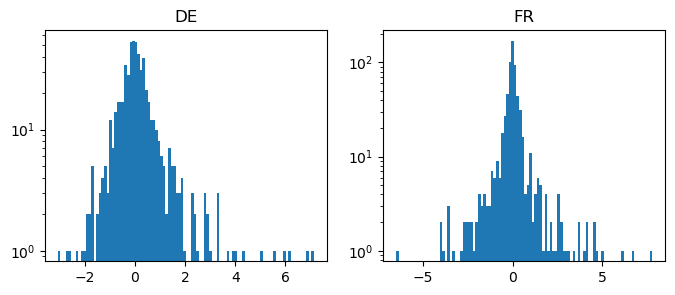

In [1209]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
for ii, (key, grp) in enumerate(f_tot.groupby("COUNTRY")):
    ax[ii].hist(np.array(grp["TARGET"]),bins=100)
    # ax[ii].set_xlim([-4,4])
    ax[ii].set_title(key)
    ax[ii].set_yscale("log")


if percetile_tokeep < 100:
    remove = (100 - percetile_tokeep) / 200
    idx_keep = []

    for country in countries_train:
        mask = f_tot["COUNTRY"] == country
        s = f_tot.loc[mask, "TARGET"]

        q_low, q_high = s.quantile([remove, 1 - remove])
        idx = s[(s >= q_low) & (s <= q_high)].index

        idx_keep.extend(idx)   # idx è un pd.Index

    idx_keep = pd.Index(idx_keep)
    f_tot    = f_tot.loc[idx_keep]

In [1210]:
if remove_collinearities:
    for key in feat.keys():
        ii=0
        while ii < len(feat[key]):
            feature = feat[key][ii]
            mask = (np.abs(corr_matrix[feature]) > 0.98)
            ll = list(corr_matrix[mask].index)
            ll.remove(feature)
            for kk in ll:
                if kk in feat[key]:
                    feat[key].remove(kk)
            ii = ii + 1


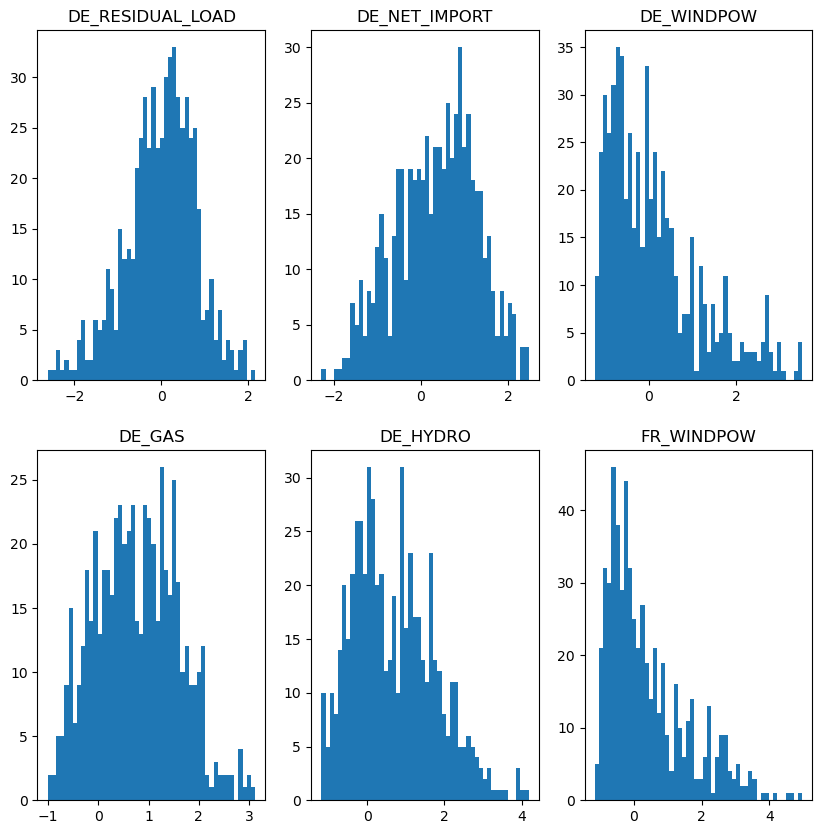

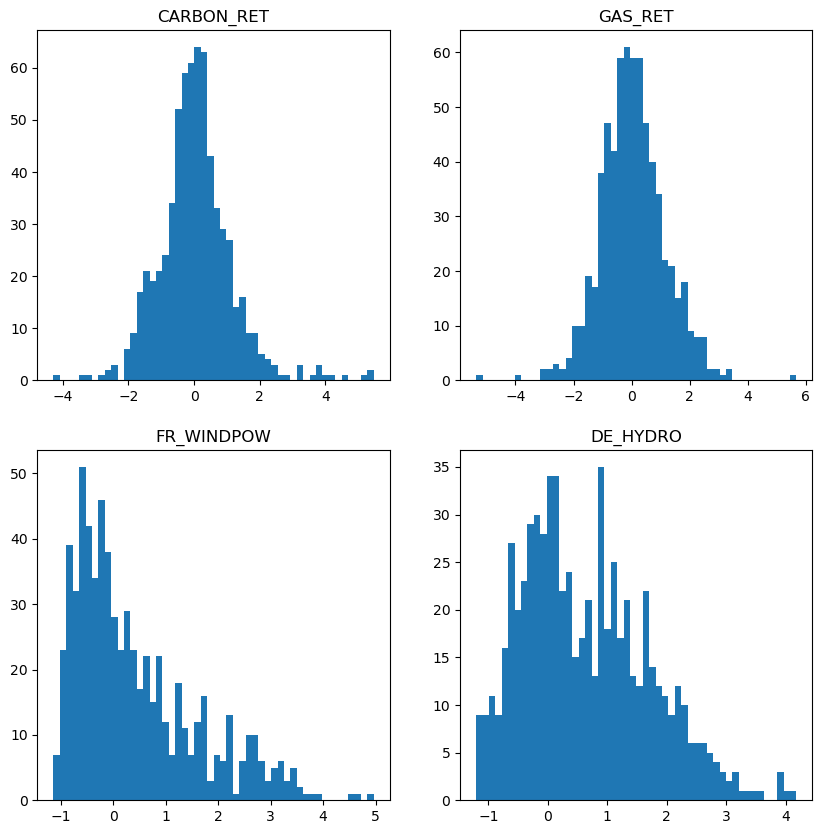

In [1211]:
for jj, (key, grp) in enumerate(f_tot.groupby("COUNTRY")):
    fig, ax = plt.subplots(2, int(len(feat[key])/3+1), figsize=(10, 10))
    ax = ax.ravel()
    for ii in range(len(feat[key])):
        col = feat[key][ii]
        try:
            ax[ii].hist(grp[col].to_numpy(), bins=50)
            ax[ii].set_title(col)
        except:
            break

if len(countries_train) == 1:
    mask = f_tot["COUNTRY"]==countries_train[0]
    f_tot = f_tot[mask]


In [1212]:
from sklearn.metrics import mean_squared_error

class metric_obj:
    def __init__(self):
        self.rmse = {}
        self.spear_corr = {}
        self.rmse_tr = {}
        self.spear_corr_tr = {}
        self.spear_corr_country = {}
        self.spear_corr_country["FR"] = {}
        self.spear_corr_country["DE"] = {}
         


    def error_metric(self, f_tot, method,indices_xval, indices_xtrain):
        mask_val_set = indices_xval
        if not(method) in self.rmse.keys():
                self.rmse[method]       = []
                self.spear_corr[method] = []
                self.rmse_tr[method]       = []
                self.spear_corr_tr[method] = []      
                self.spear_corr_country["FR"][method] = []
                self.spear_corr_country["DE"][method] = []
                      

        self.rmse[method].append(np.sqrt(mean_squared_error(f_tot.loc[mask_val_set,"TARGET"], f_tot.loc[mask_val_set,method])))
        self.spear_corr[method].append(spearmanr(f_tot.loc[mask_val_set,method], f_tot.loc[mask_val_set,"TARGET"]).correlation)

        mask_tr_set = indices_xtrain
        self.rmse_tr[method].append(np.sqrt(mean_squared_error(f_tot.loc[mask_tr_set,"TARGET"], f_tot.loc[mask_tr_set,method+"train"])))
        self.spear_corr_tr[method].append(spearmanr(f_tot.loc[mask_tr_set,method+"train"], f_tot.loc[mask_tr_set,"TARGET"]).correlation)

        country = f_tot.loc[mask_tr_set[0],"COUNTRY"]
        self.spear_corr_country[country][method].append(spearmanr(f_tot.loc[mask_val_set,method], f_tot.loc[mask_val_set,"TARGET"]).correlation)


        return 



class params_training:
    def __init__(self, max_depth=7, svr_epsilon=0.1, svr_gamma="auto",svr_c = 1, kernel="linear"):
        self.max_depth = max_depth
        self.svr_eps   = svr_epsilon
        self.svr_gamma = svr_gamma
        self.svr_c     = svr_c
        self.kernel     = kernel

# Definisci un "modello" fittizio che restituisce sempre questo valore medio
class AverageModel:
    def __init__(self, constant):
        self.constant = constant
    def predict(self, X):
        return np.full(len(X), self.constant)


metric = metric_obj()  
params = params_training()  


In [1213]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression


def features_selection(df_tr, features=[]):
    if len(features) == 0:
       X_train = df_tr.drop(columns=["COUNTRY"]).fillna(0)
    else:
       X_train = df_tr[features].fillna(0)
    return X_train


def correlation_weighting(X_train, y_train, X_val, X_test_feat):
       mi = mutual_info_regression(X_train, y_train, random_state=0)
       mi = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)

       for c in list(X_train.columns):
           weight = 1 + np.abs(mi.loc[c])**1

           X_train[c] = X_train[c] * weight
           X_val[c]   = X_val[c] * weight
           X_test_feat[c]   = X_test_feat[c] * weight

       return X_train, X_val, X_test_feat


In [1214]:
def make_pairwise_data(X, y, max_pairs=None):
    n = len(y)
    Z = []
    T = []

    for i in range(n):
        for j in range(i + 1, n):
            if y[i] == y[j]:
                continue
            Z.append(X[i] - X[j])
            T.append(1 if y[i] > y[j] else 0)

            if max_pairs and len(Z) >= max_pairs:
                break
        if max_pairs and len(Z) >= max_pairs:
            break

    return np.asarray(Z), np.asarray(T)



In [1215]:
from sklearn.linear_model import Lasso, ElasticNet, SGDClassifier
from sklearn.svm import SVR
import xgboost as xgb
from scipy.stats import rankdata
from sklearn.model_selection import KFold
import pdb




def regression_interface(f_tot, Y_test_submission_all, feat, params, method="LR", train_by_rank=False, k_fold_cross_validation=False):

       Y_test_submission_all[method] = None
       f_tot[method]                 = np.nan
       f_tot[method+"train"]         = np.nan

       for country in countries_train:                            
              f_tot, Y_test_submission_all = regression_train_with_dataset(f_tot, feat, country, method, Y_test_submission_all, 
                                                               params, train_by_rank, k_fold_cross_validation)
       return Y_test_submission_all, f_tot

def regression_train_with_dataset(df, feat, country, method, Y_test_submission_all, params, train_by_rank, k_fold_cross_validation):
       mask    = (X_test["COUNTRY"]==country)
       mask_df = (df["COUNTRY"]==country)
       
       X_tot                                = features_selection(df[mask_df].drop(columns=["TARGET"]), feat[country])
       X_test_feat                          = features_selection(X_test[mask],feat[country])
       y_tot                                = df[mask_df]["TARGET"]

       if k_fold_cross_validation:
              kf = KFold(n_splits=N_SPLIT)
              for train_index, test_index in kf.split(X_tot):
                     X_train, X_val = pd.DataFrame(X_tot.iloc[train_index]), pd.DataFrame(X_tot.iloc[test_index])
                     y_train, y_val = y_tot.iloc[train_index], y_tot.iloc[test_index]
                     df, Y_test_submission_all = training_model(X_train, y_train, X_val, y_val, X_test_feat, df, feat, country, method, Y_test_submission_all,
                                     params, train_by_rank)

       else:
              X_train, X_val, y_train, y_val = train_test_split(X_tot, y_tot, test_size=VAL_FRACTION, random_state=1)
              df, Y_test_submission_all = training_model(X_train, y_train, X_val, y_val, X_test_feat, df, feat, country, method, Y_test_submission_all, 
                             params, train_by_rank)


       return df, Y_test_submission_all


def training_model(X_train, y_train, X_val, y_val, X_test_feat, df, feat, country, method, Y_test_submission_all, 
                             params, train_by_rank):
       indices_xval     = X_val.index
       indices_xtest    = X_test_feat.index
       indices_xtrain   = X_train.index

       if train_by_rank:
              y_train[:] = rankdata(y_train.values)

       if SCALING_INPUT:
              scaler           = StandardScaler().fit(X_train)
              X_train          = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
              X_val            = pd.DataFrame(scaler.transform(X_val), index=X_val.index, columns=X_val.columns)
              X_test_feat      = pd.DataFrame(scaler.transform(X_test_feat), index=X_test_feat.index, columns=X_test_feat.columns)


       X_np = X_train.values        # or X.to_numpy()
       y_np = y_train.values        # if y is a Series


       if "classifier" == method:
              Z_train, T_train = make_pairwise_data(X_np, y_np, max_pairs=5000000)
              model = SGDClassifier(loss="log_loss", fit_intercept=False).fit(Z_train, T_train)


       if "LR" == method:
              model                                = LinearRegression().fit(X_train, y_train)
       elif "lasso" == method:
              model                                = Lasso(alpha=0.2, max_iter=100, random_state=0).fit(X_train, y_train)
       elif "elasticnet" == method:
              model                                = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=0).fit(X_train, y_train)
       elif "svr" == method:
              model                                = SVR(kernel=params.kernel,C=params.svr_c,epsilon=params.svr_eps, gamma=params.svr_gamma).fit(X_train, y_train)
       elif "RF" == method:
              model =  RandomForestRegressor(n_estimators=200,  max_depth=params.max_depth, bootstrap=True, random_state=42).fit(X_train, y_train)
       elif "RFboost" == method:
              model = GradientBoostingRegressor(n_estimators=400, learning_rate=0.01, loss="huber",  
                                          max_depth=4, min_samples_leaf=5, random_state=42).fit(X_train, y_train)
       elif "linearboost" == method:
              model         = LinearRegression().fit(X_train, y_train)
              residual      = y_train - model.predict(X_train)
              model_b       = GradientBoostingRegressor(n_estimators=200, learning_rate=0.02, loss="huber",  
                                          max_depth=3, min_samples_leaf=5, random_state=42).fit(X_train, residual)
       elif "linear_boost" == method:
              model         = LinearRegression().fit(X_train, y_train)
              residual      = y_train - model.predict(X_train)
              model_b       = SVR(kernel=params.kernel,C=params.svr_c,epsilon=params.svr_eps, gamma=params.svr_gamma).fit(X_train, residual)

       elif "xgboost" == method:
  
              dtrain = xgb.DMatrix(X_train.to_numpy(), label=y_train)
              dval   = xgb.DMatrix(X_val.to_numpy(),   label=y_val)
              model = xgb.train(params, dtrain, num_boost_round=500)
              y_pred = model.predict(dval)

              X_train       = xgb.DMatrix(X_train.to_numpy())
              X_val         = xgb.DMatrix(X_val.to_numpy())
              X_test_feat   = xgb.DMatrix(X_test_feat.to_numpy())

       if not(method=="classifier"):
              y_tr_pred   = model.predict(X_train)      
              y_pred      = model.predict(X_val)            
              Y_test      = model.predict(X_test_feat)
              if 'model_b' in locals():
                     y_tr_pred   += model_b.predict(X_train)      
                     y_pred      += model_b.predict(X_val)            
                     Y_test      += model_b.predict(X_test_feat)

       else:
              w = model.coef_.ravel()
              y_tr_pred  = X_train.to_numpy() @ w
              y_pred = X_val.to_numpy()   @ w
              Y_test     = X_test_feat.to_numpy() @ w
              
       Y_test_submission_all.loc[indices_xtest, method] = Y_test
       df.loc[indices_xval, method]           = y_pred
       df.loc[indices_xtrain, method+"train"] = y_tr_pred

       metric.error_metric(f_tot, method, indices_xval, indices_xtrain)
       return df, Y_test_submission_all

In [1216]:
metric.rmse = {}
metric.spear_corr = {}

params = params_training(max_depth=7,svr_epsilon=0.01,svr_gamma=0.01,svr_c=0.01,kernel="rbf")
Y_test_submission_all = X_test[['ID']].copy()

method="LR"
Y_test_submission_all,  f_tot  = regression_interface(f_tot, Y_test_submission_all,  feat, params, method=method, train_by_rank=train_by_rank, k_fold_cross_validation=k_fold_cross_valid)
print(np.array(metric.rmse[method]).mean(), np.array(metric.spear_corr[method]).mean(), method)


method="lasso"
Y_test_submission_all,  f_tot  = regression_interface(f_tot, Y_test_submission_all,  feat, params, method=method, train_by_rank=train_by_rank, k_fold_cross_validation=k_fold_cross_valid)
print(np.array(metric.rmse[method]).mean(), np.array(metric.spear_corr[method]).mean(), method)

method="svr"
Y_test_submission_all,  f_tot  = regression_interface(f_tot, Y_test_submission_all,  feat, params, method=method, train_by_rank=train_by_rank, k_fold_cross_validation=k_fold_cross_valid)
print(np.array(metric.rmse[method]).mean(), np.array(metric.spear_corr[method]).mean(), method)

method="linearboost"
Y_test_submission_all,  f_tot  = regression_interface(f_tot, Y_test_submission_all,  feat, params, method=method, train_by_rank=train_by_rank, k_fold_cross_validation=k_fold_cross_valid)
print(np.array(metric.rmse[method]).mean(), np.array(metric.spear_corr[method]).mean(), method)

method="linear_boost"
Y_test_submission_all,  f_tot  = regression_interface(f_tot, Y_test_submission_all,  feat, params, method=method, train_by_rank=train_by_rank, k_fold_cross_validation=k_fold_cross_valid)
print(np.array(metric.rmse[method]).mean(), np.array(metric.spear_corr[method]).mean(), method)

method = "RFboost"
Y_test_submission_all,  f_tot  = regression_interface(f_tot, Y_test_submission_all,  feat, params, method=method, train_by_rank=train_by_rank, k_fold_cross_validation=k_fold_cross_valid)
print(np.array(metric.rmse[method]).mean(), np.array(metric.spear_corr[method]).mean(), method)

params = {"booster": "gbtree","objective": "reg:squarederror","eta": 0.02,"max_depth": 3,
    "min_child_weight": 0.3, "subsample": 1, "colsample_bytree": 0.4, "gamma" : 0.1,"reg_alpha": 1,  # L1
    "reg_lambda": 5  # L2
}

method="xgboost"
Y_test_submission_all, f_tot  = regression_interface(f_tot, Y_test_submission_all,  feat, params, method=method, train_by_rank=train_by_rank, k_fold_cross_validation=k_fold_cross_valid)
print(np.array(metric.rmse[method]).mean(), np.array(metric.spear_corr[method]).mean(), method)



254.85098583868458 0.2849125859648161 LR
254.7744604147014 0.2850567240312433 lasso
250.52718013639054 0.28059712904534007 svr
256.1822260416592 0.28872249255416205 linearboost
250.0583347429747 0.28502686730630733 linear_boost
257.6349672438324 0.24335277510661588 RFboost
257.1044240216139 0.2809027628517047 xgboost


In [1217]:
print("training set (averaged between the countries)")

for mm in metric.rmse.keys():
    print(np.array(metric.rmse_tr[mm]).mean(), np.array(metric.spear_corr_tr[mm]).mean(), mm)

print("\n-------validation------------------")

for cc in countries_train:
    print(cc)
    for kk in metric.spear_corr_country[cc].keys():
        mean = np.array(metric.spear_corr_country[cc][kk]).mean()
        print(kk, mean)
    print("-------------------")


training set (averaged between the countries)
254.8381592556782 0.31332293001295297 LR
254.76742472115453 0.3129789731585345 lasso
250.52735362487337 0.2904032022084107 svr
256.66919938400895 0.619180999208298 linearboost
250.0497448268115 0.313315267501174 linear_boost
259.32741078795397 0.7744715189627114 RFboost
258.2438006805947 0.7133966453342901 xgboost

-------validation------------------
DE
LR 0.320519023408765
lasso 0.320931854802716
svr 0.3118614747385108
linearboost 0.32081892560890346
linear_boost 0.3208503310274458
RFboost 0.3132204953585788
xgboost 0.3043130152222877
-------------------
FR
LR 0.24930614852086733
lasso 0.24918159325977068
svr 0.2493327833521694
linearboost 0.2566260594994206
linear_boost 0.2492034035851689
RFboost 0.17348505485465288
xgboost 0.2574925104811217
-------------------


In [1218]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau


def NN_prep(f_tot, X_test, country, criterion, residual_meth=None):
    mask_tr   = (f_tot["COUNTRY"] == country)
    mask_test = (X_test["COUNTRY"] == country)
    
    X_tot                                = features_selection(f_tot[mask_tr].drop(columns=["TARGET"]), feat[country])
    X_test_feat                          = features_selection(X_test[mask_test],feat[country])

    if residual_meth is not None:    
        y_tot = f_tot[mask_tr]["TARGET"] - f_tot[mask_tr][residual_meth + "train"].fillna(f_tot[residual_meth])

        if isinstance(criterion, nn.HuberLoss):
            delta = criterion.delta  # usa 1.0 se non esiste
            y_tot = y_tot.clip(-delta, delta)         # <-- CLIPPING in pandas

    else:
        y_tot = f_tot[mask_tr]["TARGET"]

    X_train, X_val, Y_train, Y_val       = train_test_split(X_tot, y_tot, test_size=VAL_FRACTION, random_state=1)

    scaler           = StandardScaler().fit(X_train)
    X_train          = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_val            = pd.DataFrame(scaler.transform(X_val), index=X_val.index, columns=X_val.columns)
    X_test_feat      = pd.DataFrame(scaler.transform(X_test_feat), index=X_test_feat.index, columns=X_test_feat.columns)


    x_train = torch.tensor(X_train.values, dtype=torch.float32).view(-1, len(feat[country]))
    y_train = torch.tensor(Y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
    x_val   = torch.tensor(X_val.values, dtype=torch.float32).view(-1, len(feat[country]))
    y_val   = torch.tensor(Y_val.to_numpy(), dtype=torch.float32).view(-1, 1)

    # Setup data loaders for batch
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    val_dataset = TensorDataset(x_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    return val_loader, val_dataset, train_loader, train_dataset, X_test_feat, X_train, Y_train, X_val, Y_val


In [1219]:
import torch.nn.functional as F
class MLPModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        # self.fc2 = nn.Linear(256, 128)
        # self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1)
        self.fdrop_1 =  nn.Dropout(p=0.1)   # ← qui
        self.fdrop_2 =  nn.Dropout(p=0.0)   # ← qui

    def forward(self, x):
        # x = self.fc1(x)
        x = F.relu(self.fc1(x))

        x = self.fdrop_1(x)

        # x = F.relu(self.fc3(x))
        # x = self.fdrop_2(x)

        x = F.relu(self.fc4(x))

        x = self.fc5(x)
        return x.squeeze(1)  #
    


def training_NN(model, val_loader, train_loader, criterion, optimizer, epochs, scheduler, l1_lambda, l2_lambda, early_stop_treshold, verbose=False):
    early_stop_count = 0
    min_val_loss = float('inf')

    best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}

    for epoch in range(epochs):
        model.train()
        train_losses = []

        # Training
        for batch in train_loader:
            x_batch, y_batch = batch
            y_batch = y_batch.squeeze(-1)

            optimizer.zero_grad()
            outputs = model(x_batch).view(-1)
            loss = criterion(outputs, y_batch)

            # add manually L1 and L2 regulatization
            l1_norm = sum(p.abs().sum() for p in model.parameters())

            l2_norm = sum(p.pow(2).sum() for p in model.parameters())

            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm

            train_losses.append(loss.item())

            if not torch.isfinite(loss):
                continue

            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in val_loader:
                x_batch, y_batch = batch
                y_batch = y_batch.squeeze(-1)

                outputs = model(x_batch).view(-1)
                loss = criterion(outputs, y_batch)

                if torch.isfinite(loss):
                    val_losses.append(loss.item())

        if len(val_losses) == 0:
            continue

        val_loss = np.mean(val_losses)
        scheduler.step(val_loss)

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
            early_stop_count = 0
        else:
            early_stop_count += 1

        if early_stop_count >= early_stop_treshold:
            if verbose:
                print("Early stopping!")
            break

        if epoch % 5 == 0 and verbose:
            print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.8f}, Train Loss: {np.mean(train_losses):.8f}")

    model.load_state_dict(best_state)
    return model




def pred_NN_learning(country, model, Y_test_submission_all, df, X_train, Y_train, X_val, Y_val, X_test_feat, method, alpha_boost, boosting_met ):
    model.eval()
    with torch.no_grad():
        x_train = torch.tensor(X_train.values, dtype=torch.float32).view(-1, len(feat[country]))
        x_val   = torch.tensor(X_val.values, dtype=torch.float32).view(-1, len(feat[country]))
        x_test  = torch.tensor(X_test_feat.values, dtype=torch.float32).view(-1, len(feat[country]))

        y_pred_train = model(x_train).numpy()  
        y_pred_val  = model(x_val).numpy() 

        Y_test       = model(x_test).numpy()

        if not(boosting_met == None):
            y_pred_val  = df.loc[X_val.index, boosting_met]  + alpha_boost * y_pred_val 
            y_pred_train = df.loc[X_train.index, boosting_met+"train"]+ alpha_boost * y_pred_train
            Y_test       = Y_test_submission_all.loc[X_test_feat.index, boosting_met] + alpha_boost * Y_test


        df.loc[X_val.index, method]           = y_pred_val
        df.loc[X_train.index, method+"train"] = y_pred_train

        Y_test_submission_all.loc[X_test_feat.index, method] = Y_test
   
    return df


def plot_learning(f_tot,method, figsize=(10,4)):
        

    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=figsize)
    fig.subplots_adjust(wspace=0.4)

    for jj, (key, df) in enumerate(f_tot.groupby("COUNTRY")):
        mask_tr    =  np.isfinite(df[method+"train"])
        mask_val   =  np.isfinite(df[method])
        ax[1].scatter(df[mask_tr]["TARGET"], df[mask_tr][method+"train"], s=5, alpha=0.5,label=key)
        ax[1].set_xlabel("True y (train)")
        ax[1].set_ylabel("Predicted y")
        ax[1].set_title("Train fit "+method)
        ax[1].plot([df[mask_tr]["TARGET"].min(), df[mask_tr]["TARGET"].max()], [df[mask_tr]["TARGET"].min(), df[mask_tr]["TARGET"].max()], 'r--')
        ax[1].set_xlim([-3,3])
        ax[1].set_ylim([df[mask_tr][method+"train"].min(),df[mask_tr][method+"train"].max()])

        ax[0].scatter(df[mask_val]["TARGET"], df[mask_val][method], s=5, alpha=0.5)
        ax[0].plot([df[mask_val]["TARGET"].min(), df[mask_val]["TARGET"].max()], [df[mask_val]["TARGET"].min(), df[mask_val]["TARGET"].max()], 'r--')

        ax[0].set_xlabel("True y (test)")
        ax[0].set_ylabel("Predicted y")
        ax[0].set_title("Test fit "+method)

        ax[0].set_xlim([-2,2])
        ax[0].set_ylim([df[mask_val][method].min(),df[mask_val][method].max()])
    ax[1].legend()
    
    return 

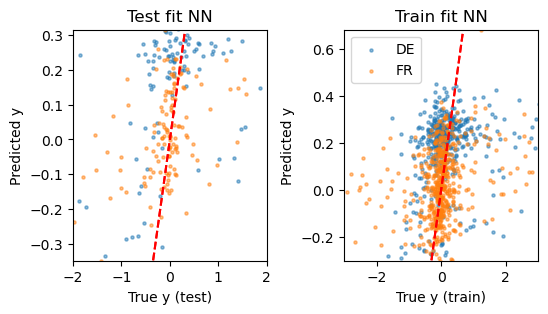

[np.float64(0.36361800022444174)]


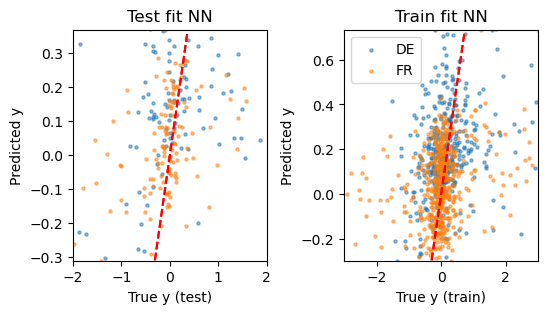

[np.float64(0.36361800022444174), np.float64(0.3762515742091547)]


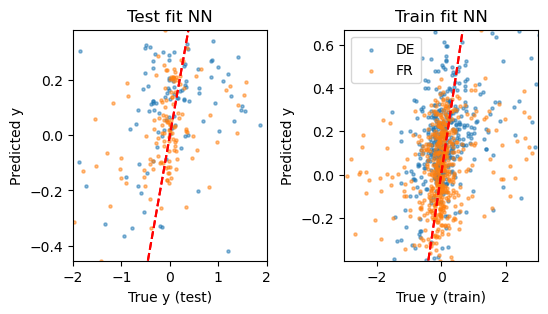

[np.float64(0.36361800022444174), np.float64(0.3762515742091547), np.float64(0.3593137071534558)]


In [1220]:


if NN:
    epochs = 200
    starting_methods = NN_bosting_method
    alpha_boost = 1
    early_stop_treshold = 1000
    old_spear_corr = 0
    verbose = False
    ori_methods = ["NN"]

    l1_lambda = 1e-3
    l2_lambda = 0*1e-5

    for initial_pred in starting_methods:
        methods     = ori_methods.copy()
        if not(initial_pred == None):
            for ii in range(len(ori_methods)):
                methods[ii] = initial_pred+ori_methods[ii]

        for method, criterion in zip(methods, [nn.MSELoss()]):
            metric.spear_corr[method] = []
            metric.spear_corr_tr[method] = []
            boosting_met    = initial_pred
            criterion_boost = nn.MSELoss() 
            for iter_boost in range(boosting_rounds):
                for country in countries_train:
                    
                    test_loader, test_dataset, train_loader, train_dataset, X_test_feat, X_train, Y_train, X_val, Y_val =  NN_prep(f_tot, X_test, country, criterion_boost, residual_meth=boosting_met)
                    x_train = torch.tensor(X_train.values, dtype=torch.float32).view(-1, len(feat[country]))

                    model = MLPModel(input_dim=x_train.shape[1])
                    
                    optimizer = torch.optim.Adam(model.parameters(), lr=4e-3, weight_decay = 0)
                    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.8, patience=100)
                    model = training_NN(model,test_loader, train_loader, criterion, optimizer,epochs,scheduler, l1_lambda, l2_lambda, early_stop_treshold, verbose)

                    f_tot = pred_NN_learning(country, model, Y_test_submission_all, f_tot, X_train, Y_train, X_val, Y_val, X_test_feat, method, alpha_boost, boosting_met )

                plot_learning(f_tot,method,figsize=(6,3))
                plt.show()


                boosting_met    = method
                criterion_boost = criterion

                metric.error_metric(f_tot, method, X_val.index, X_train.index)
                if not(initial_pred==None):
                    diff = f_tot.loc[X_val.index, method] - f_tot.loc[X_val.index, initial_pred]
                    print(method, initial_pred)
                    print(metric.spear_corr[method], metric.spear_corr[initial_pred])
                    print("-----------------------------")
                else:
                    print(metric.spear_corr[method])




Overview of the performance of the several models and sorting of methods according to their performance on validation set

In [1221]:
spear_corr_vect_models = {}
models                 = {}
for cc in countries_train:
    spear_corr_vect_models[cc] = []


    models[cc] = list(metric.spear_corr_country[cc].keys())
    for kk in metric.spear_corr_country[cc].keys():
        spear_corr_vect_models[cc].append(np.array(metric.spear_corr_country[cc][kk]).mean())
        
    argsort     = np.argsort(spear_corr_vect_models[cc])[::-1]
    models[cc]  = np.asarray(models[cc])[argsort]
    spear_corr_vect_models[cc] = np.asarray(spear_corr_vect_models[cc])[argsort]


C:\Users\Administrator\AppData\Local\Temp\ipykernel_25200\3576770257.py:9: RuntimeWarning: Mean of empty slice.
  spear_corr_vect_models[cc].append(np.array(metric.spear_corr_country[cc][kk]).mean())
c:\ProgramData\miniconda3\envs\ML_python\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [1222]:

Y_test_submission_G = Y_test_submission_all[['ID']].copy()
Y_test_submission_G["TARGET"] = Y_test_submission_all[models[countries_train[0]][0]]

print("\nUsing the following model which has the following spearman correlation on the validation set:")
for cc in countries_train:
    print("for " + cc + ": "+ str(models[cc][0]) + " with sp. " + str(spear_corr_vect_models[cc][0]))
    mask = (X_test["COUNTRY"] == cc)

    Y_test_submission_G.loc[mask, "TARGET"] = Y_test_submission_all.loc[mask, models[cc][0]]

Y_test_submission_G.to_csv('benchmark_qrt_G.csv', index=False)



Using the following model which has the following spearman correlation on the validation set:
for DE: NN with sp. nan
for FR: NN with sp. 0.3663944271956841


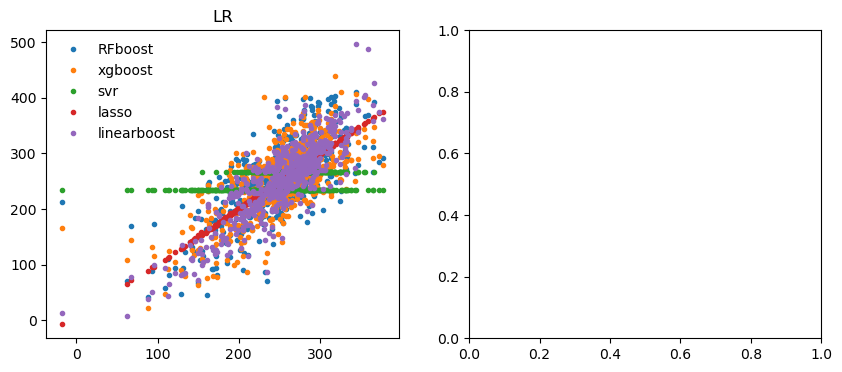

In [1223]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,4))

model_x = ["LR", "RFboostNN-Hub_multiple", "xgboostNN-Hub_multiple"]
model_y = ["LR", "RFboostNN-Hub_multiple", "xgboostNN-Hub_multiple", "RFboost","xgboost","svr","lasso", "linearboost"]
ii=-1
for mx in model_x:
    ii = ii +1
    for my in model_y:
        if my == mx:
            continue
        if not(mx in Y_test_submission_all and my in Y_test_submission_all):
            continue
        ax[ii].plot(Y_test_submission_all[mx], Y_test_submission_all[my],".",label=my)
        ax[ii].set_title(mx)
        ax[ii].legend(framealpha=0.0)       
